In [1]:
import torch
from nd_scaffold import GridModule

mod = GridModule(shape=(3, 3, 5), device="cpu:0", T=0.1)

print("state", mod.state)
print("one hot", mod.onehot())

mod.denoise_self()

print("state", mod.state)
print("one hot", mod.onehot())

mod.shift(torch.tensor([1, 0, 0], device="cpu:0"))

print("state", mod.state)
print("one hot", mod.onehot())

mod.denoise_self()

print("state", mod.state)
print("one hot", mod.onehot())

state tensor([[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
internal state tensor([[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
internal state tensor([[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
internal state tensor([[[1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],


In [2]:
import numpy as np
import torch
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
from graph_utils import graph_scaffold, print_imgs_side_by_side
import os


def test_mnist(
    num_imgs=1,
    prefix="",
    relu_theta=0.5,
    sparsity=0.1,
    N_h=400,
    T=0.01,
    plot_figs=False,
):
    import torchvision
    from torchvision import transforms

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float().to("cuda")[:num_imgs]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    shapes = [(3, 3, 5), (4, 4, 7)]
    velocities = torch.tile(torch.tensor([[1, 1, 1]]), (l, 1)).to("cuda")

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device="cuda",
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device="cuda",
            ),
            relu_theta=relu_theta,
            T=T,
        )
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    if plot_figs:
        for i in range(1):
            original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
            noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
            recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
            print_imgs_side_by_side(
                original_img,
                noisy_img,
                recalled_img,
                out=f"{prefix}mnist_learned_{i}.png",
                captions=["original", "noisy", "recalled"],
                title="Learned",
            )

    similarity = torch.nn.functional.cosine_similarity(
        mnist_data, GS.recall(noisy_mnist)
    )
    return similarity


test_mnist(11, sparsity=0.99, N_h=1000, prefix="", relu_theta=0.9)

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried http://yann.lecun.com/exdb/mnist/, got:
HTTP Error 404: Not Found
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>


In [3]:
from matplotlib import pyplot as plt

temperatures = [0.001, 0.03, 0.01, 0.1, 0.3, 1]
N_h = [200, 400, 600, 800, 1000]

scores = np.zeros((len(temperatures), len(N_h)))

for i, T in enumerate(temperatures):
    for j, N in enumerate(N_h):
        scores[i, j] = (
            test_mnist(11, sparsity=0.99, N_h=N, prefix=f"T_{T}_N_{N}_").mean().item()
        )

print(scores)

fig, ax = plt.subplots()
cax = ax.matshow(scores, cmap="viridis")

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried http://yann.lecun.com/exdb/mnist/, got:
HTTP Error 404: Not Found
Tried https://ossci-datasets.s3.amazonaws.com/mnist/, got:
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>


In [4]:
import pickle

with open("scores.pkl", "wb") as f:
    pickle.dump(scores, f)

In [ ]:
fig, ax = plt.subplots()
for i, T in enumerate(temperatures):
    ax.plot(N_h, scores[i], label=f"T={T}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()

67


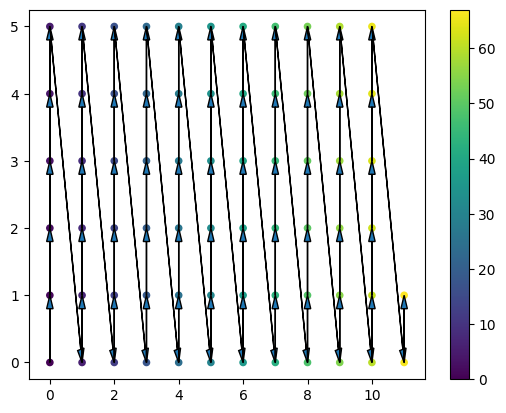

In [3]:
from vectorhash_functions import spacefillingcurve

modules = [(2, 3), (3, 4)]
v = spacefillingcurve(modules)

# graph walk

import matplotlib.pyplot as plt
import numpy as np


def plot_walk(v, modules):
    l2 = modules[0][0] * modules[1][0]
    l1 = modules[0][1] * modules[1][1]
    x = np.cumsum([0] + [i[0] for i in v]) % l1
    y = np.cumsum([0] + [i[1] for i in v]) % l2

    # plot arrows

    c = plt.scatter(x, y, c=range(len(x)), cmap="viridis", s=20)
    for i in range(len(x) - 1):
        plt.arrow(
            x[i],
            y[i],
            x[i + 1] - x[i],
            y[i + 1] - y[i],
            head_width=0.2,
            head_length=0.2,
            length_includes_head=True,
        )
    plt.colorbar(c)


print(len(v))
plot_walk(v, modules)

In [ ]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]

scores = np.zeros((len(T), len(N_h)))

for i, t in enumerate(T):
    for j, dim in enumerate(N_h):
        scores[i, j] = (
            test_mnist(
                100, sparsity=0.99, N_h=dim, prefix=f"T_{t}_N_{dim}_", plot_figs=False
            )
            .mean()
            .item()
        )

In [ ]:
T = [0.01, 0.03, 0.1, 0.3, 1]
N_h = [500, 600, 700, 800, 900]
fig, ax = plt.subplots()
for i, t in enumerate(T):
    ax.plot(N_h, scores[i], label=f"T={t}")

ax.set_xlabel("N_h")
ax.set_ylabel("Similarity")
ax.legend()
ax.legend()

/Users/Ile-Maurice/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


imgs:     133
module shapes:  [(3, 3), (4, 4)]
N_g     :  25
N_patts :  144
N_h     :  800
Denoised grid state tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
avg nonzero H: 542.4788208007812
Std nonzero H 31.89204216003418
avg nonzero H_denoised: 297.5287170410156
Std nonzero H_denoised 11.987590789794922
H_indexes: tensor([[    0,     2],
        [    0,     3],
        [    0,     4],
        ...,
        [59866,   796],
        [59866,   798],
        [59866,   799]])
G_indexes tensor([[    0,     0],
        [    0,     9],
        [    1,     1],
        ...,
        [59865,    14],
        [59866,     0],
        [59866,    12]])
G__indexes: tensor([[    0,     0],
        [    0,     9],
        [    1,     1],
        ...,
        [59865,    14],
        [59866,     0],
        [59866,    12]])
H__indexes: tensor([[    0,     2],
        [    0,     3],
        [    0,     4],
        ...,
        [59866,   7

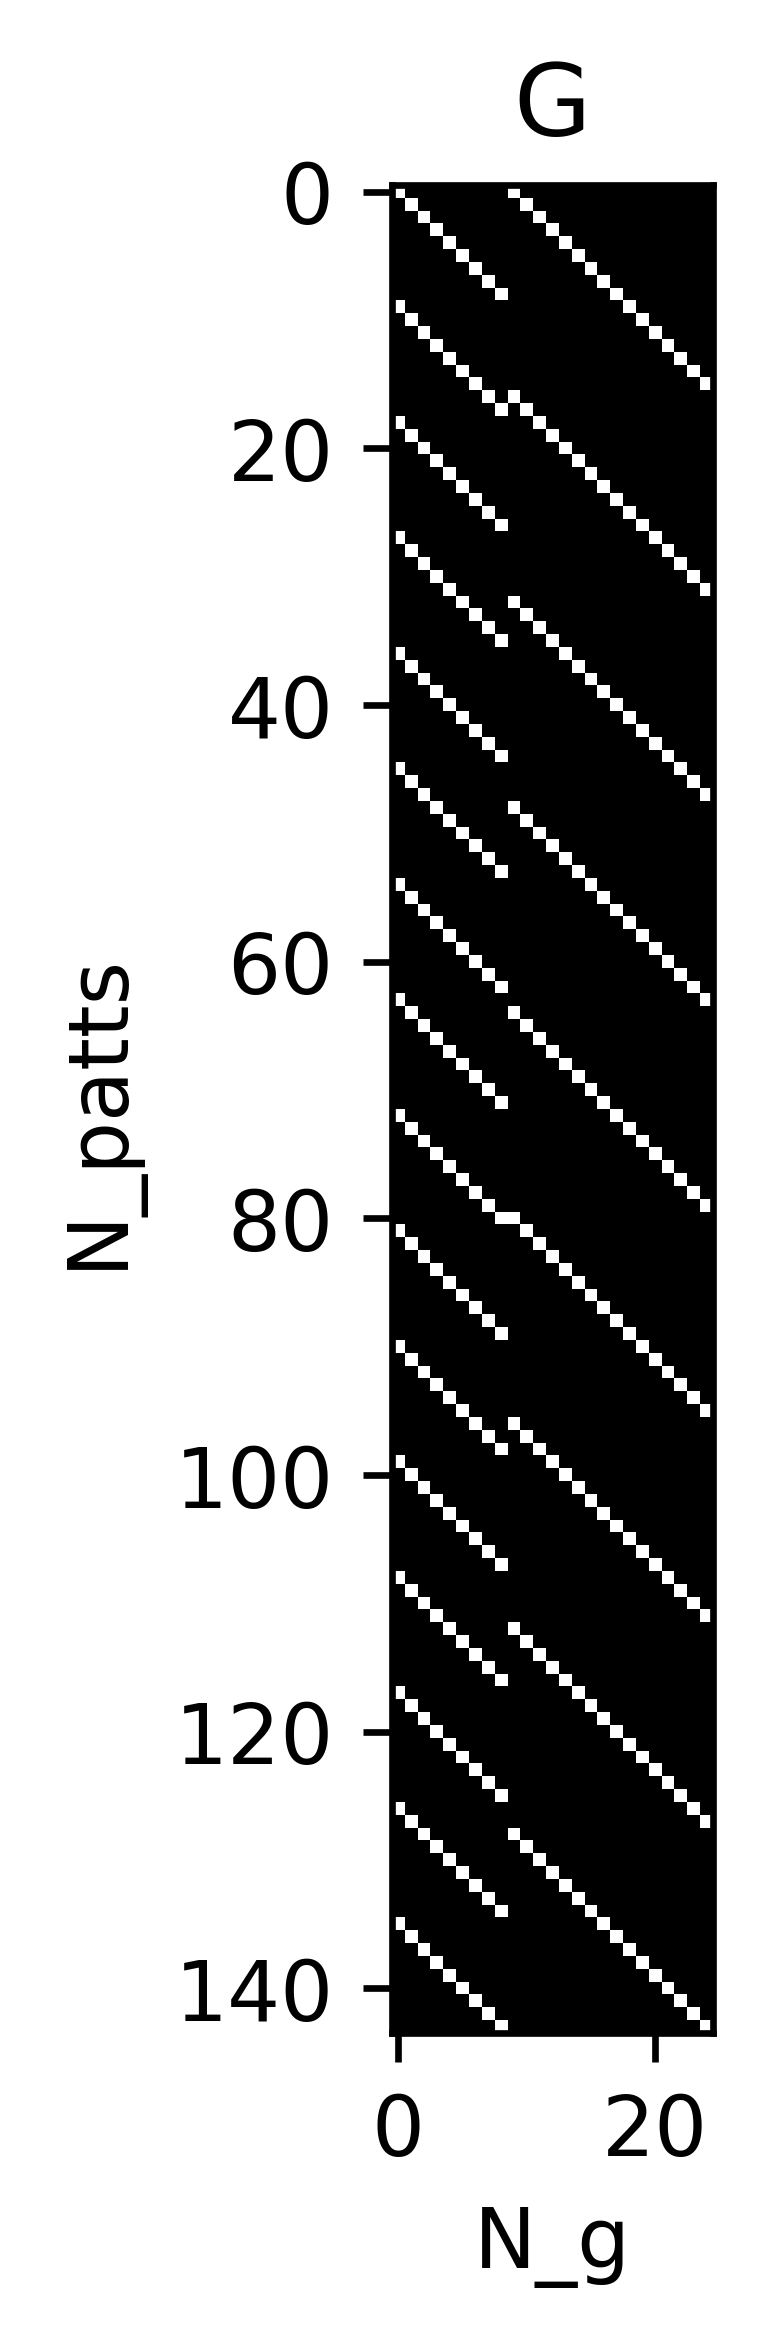

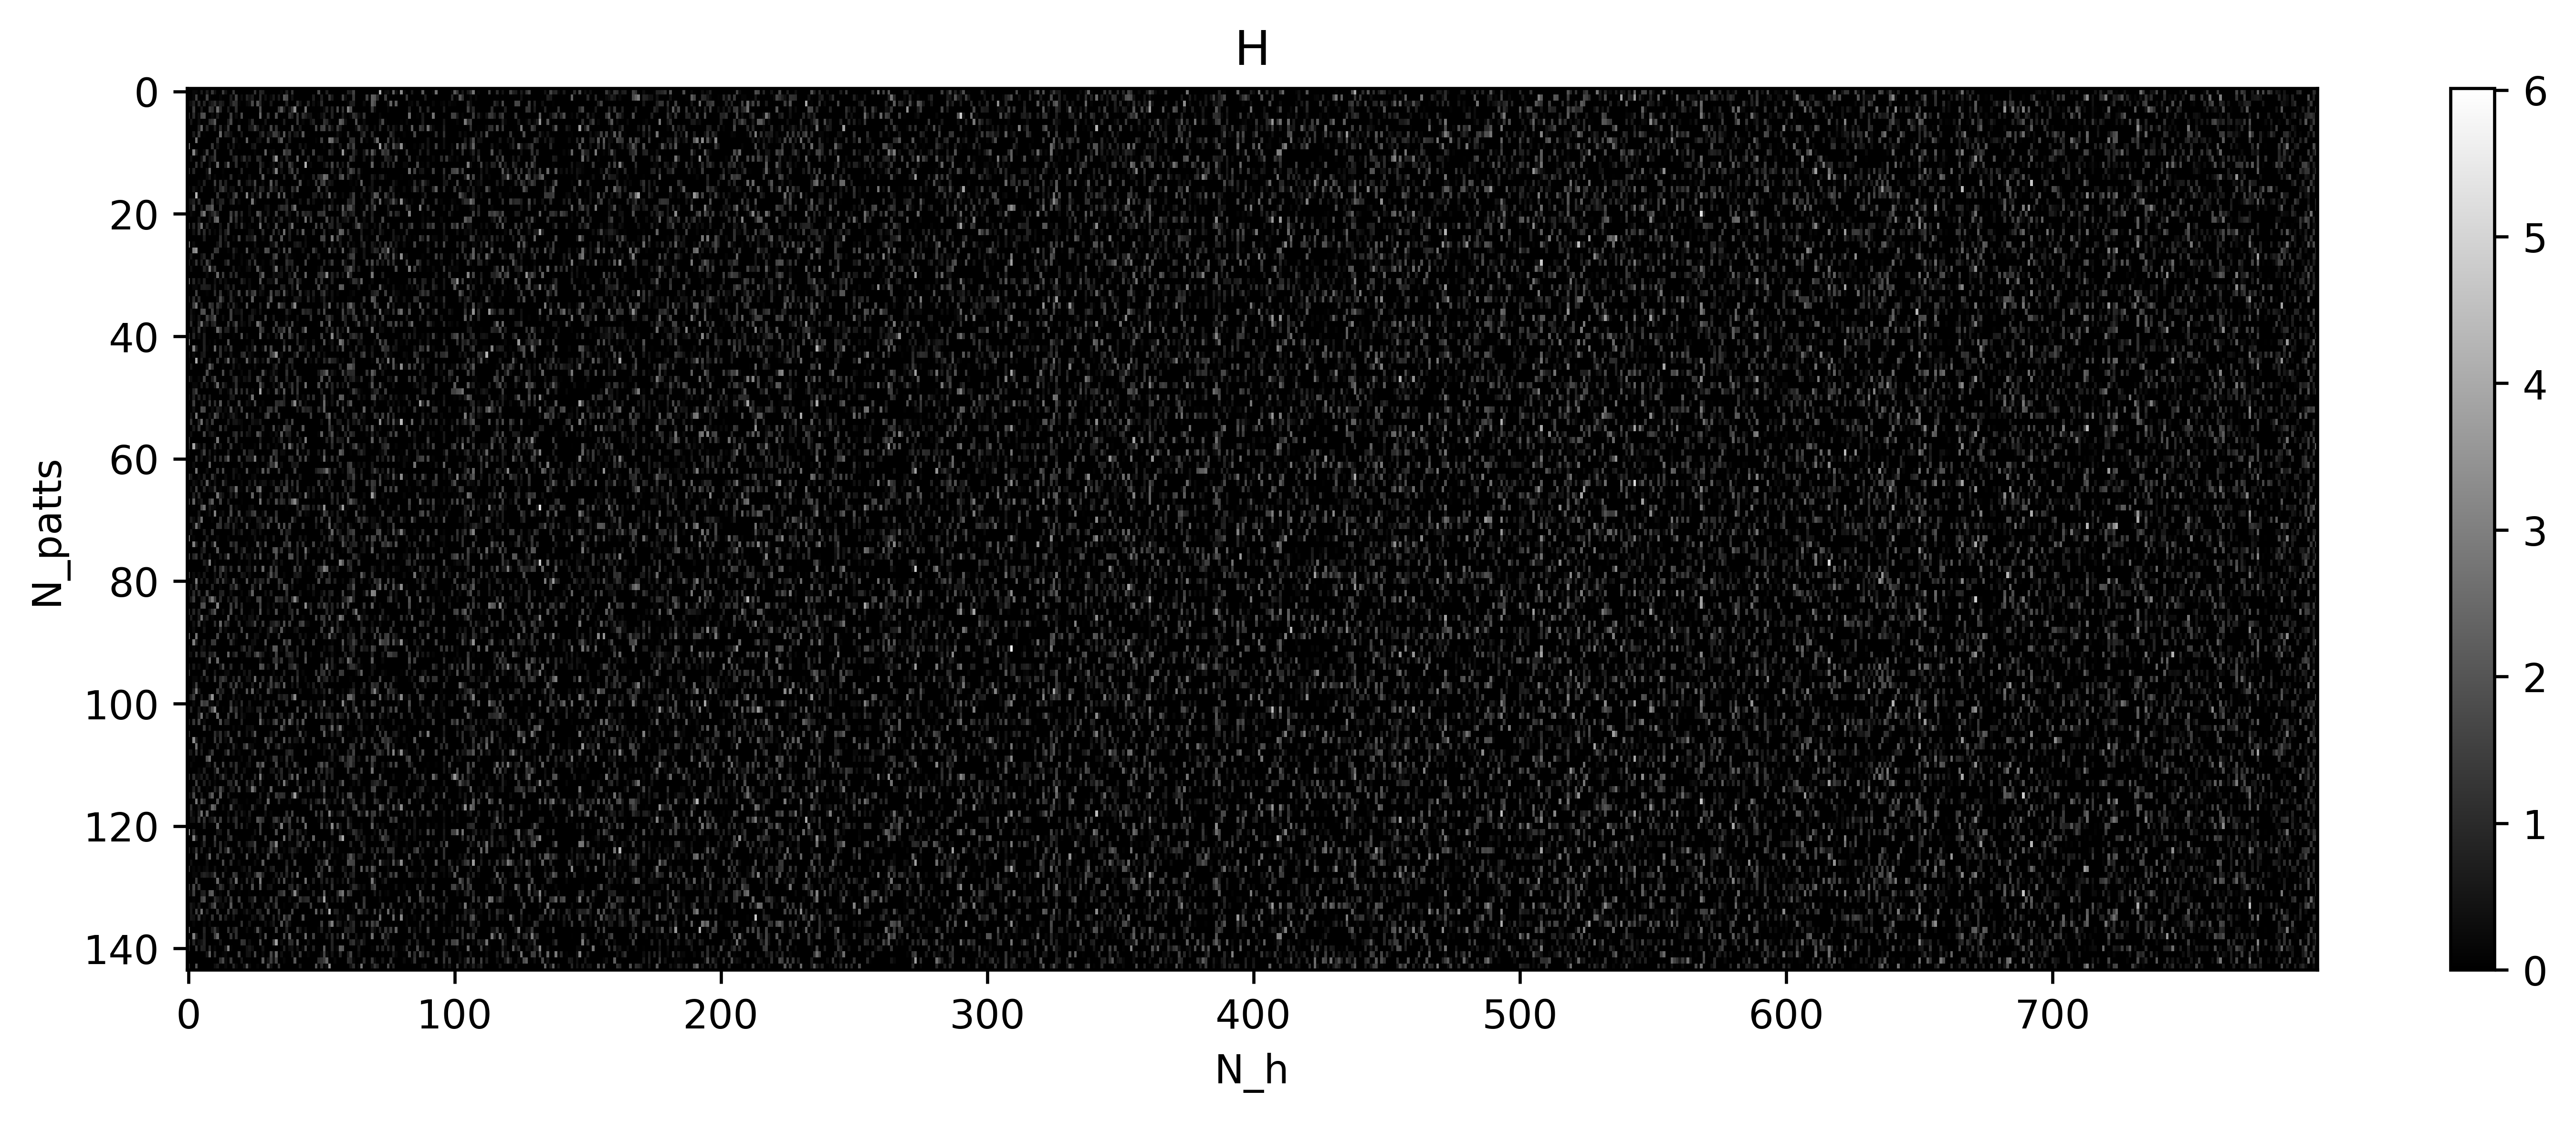

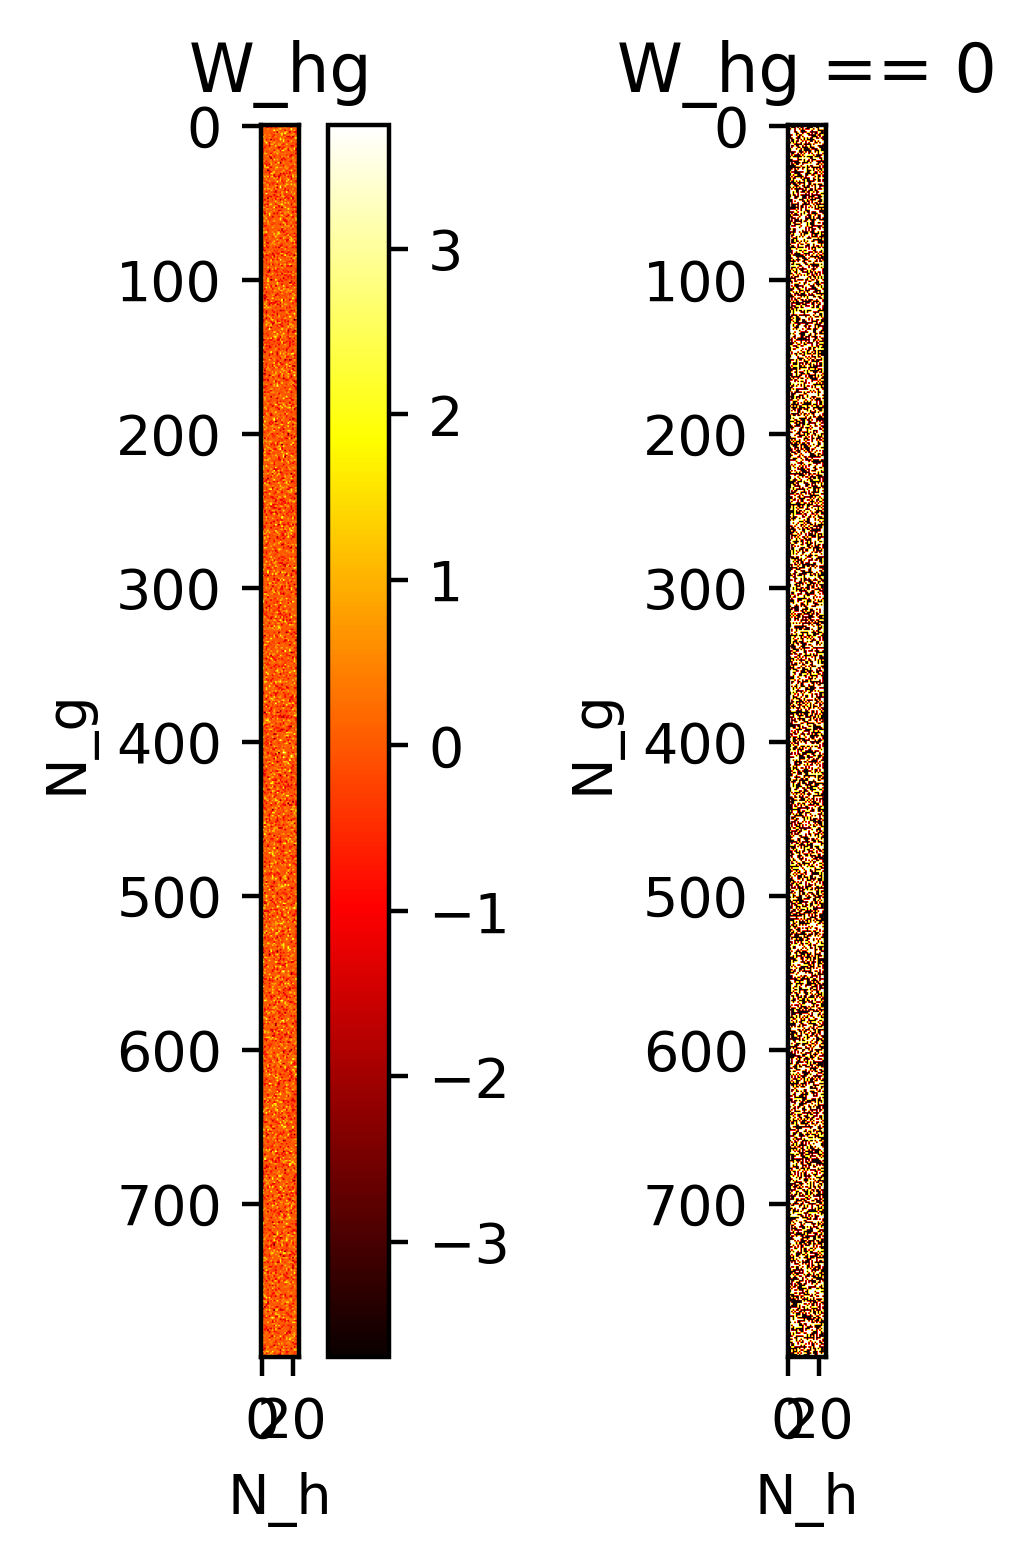

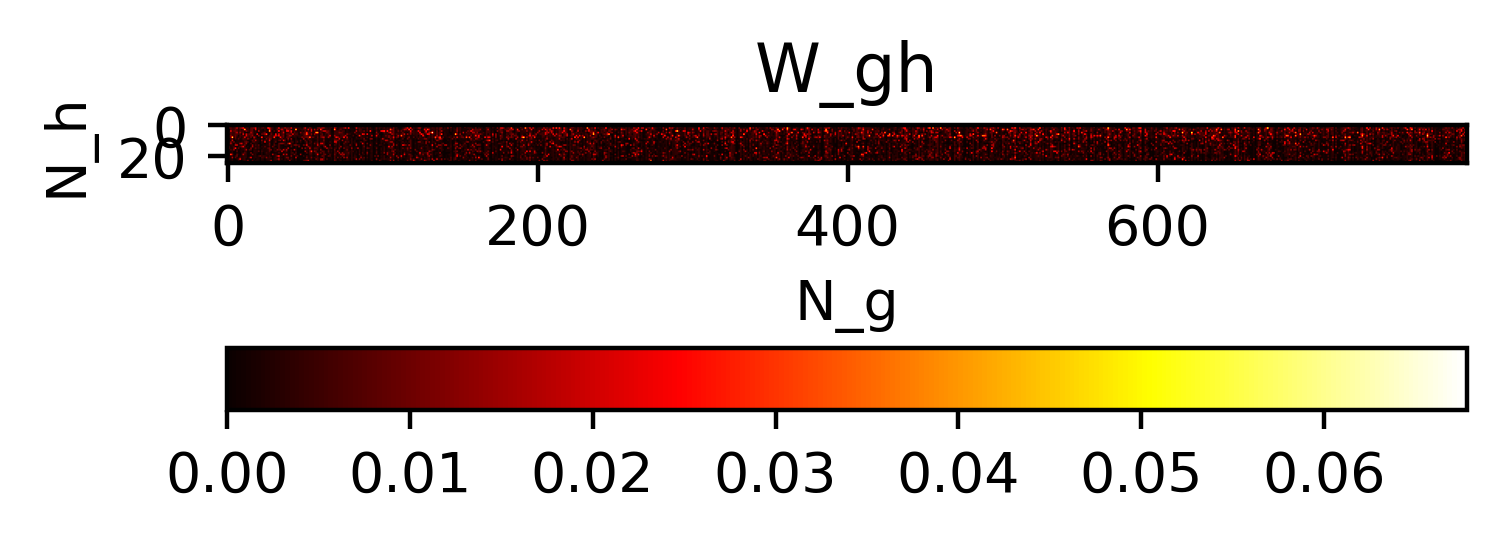

In [ ]:
from nd_scaffold import GridScaffold, SparseMatrixBySparsityInitializer
import torchvision
from torchvision import transforms
from graph_utils import print_imgs_side_by_side, graph_scaffold
from vectorhash_functions import spacefillingcurve
import torch
import os


def test_mnist2(
    percent=1,
    prefix="",
    relu_theta=0.5,
    sparsity=0.1,
    N_h=400,
    T=0.01,
    plot_figs=False,
    plot_scaffold=False,
):
    os.makedirs("mnist_test_2", exist_ok=True)

    shapes = [(3, 3), (4, 4)]
    velocities = spacefillingcurve(shapes)
    print("imgs:    ", int(len(velocities) * percent))

    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
    )

    mnist = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    mnist_data = mnist.data.flatten(1).float()[int(len(velocities) * percent) :]
    mnist_data = (mnist_data - mnist_data.mean()) / mnist_data.std()
    l = mnist_data.shape[0]

    if False and os.path.exists("checkpoint.pt"):
        GS = GridScaffold.load("checkpoint.pt", device="cuda")
    else:
        GS = GridScaffold(
            shapes=shapes,
            N_h=N_h,
            input_size=784,
            device=None,
            sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
                sparsity=sparsity,
                device=None,
            ),
            relu_theta=relu_theta,
            T=T,
        )

    if plot_scaffold:
        graph_scaffold(GS, dir="mnist_test_2")
        # GS.checkpoint("checkpoint.pt")

    # graph_scaffold(GS)

    # random_noise = torch.zeros_like(mnist_data).uniform_(-128, 128)
    noisy_mnist = mnist_data  # + random_noise
    # recalled_imgs = GS.recall(noisy_mnist)

    # for i in range(1):
    #     original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
    #     noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
    #     recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
    #     print_imgs_side_by_side(
    #         original_img,
    #         noisy_img,
    #         recalled_img,
    #         out=f"mnist_unlearned_{i}.png",
    #         captions=["original", "noisy", "recalled"],
    #         title="Unlearned",
    #     )

    GS.learn_path(observations=mnist_data, velocities=velocities)
    recalled_imgs = GS.recall(noisy_mnist)

    if plot_figs:
        for i in range(percent * len(velocities)):
            original_img = mnist_data[i].reshape(28, 28).cpu().numpy()
            noisy_img = noisy_mnist[i].reshape(28, 28).cpu().numpy()
            recalled_img = recalled_imgs[i].reshape(28, 28).cpu().numpy()
            print_imgs_side_by_side(
                original_img,
                noisy_img,
                recalled_img,
                out=f"mnist_test_2/{prefix}mnist2_LRND_{i}.png",
                captions=["original", "noisy", "recalled"],
                title="Learned",
            )

    similarity = torch.nn.functional.cosine_similarity(
        mnist_data, GS.recall(noisy_mnist)
    )
    return similarity, GS


scores, GS = test_mnist2(
    percent=1,
    sparsity=0.50,
    N_h=800,
    prefix="",
    relu_theta=0,
    T=0.0000001,
    plot_figs=True,
    plot_scaffold=True,
)
print(scores.mean().item())